# Исследование сервиса аренды самокатов GoFast

Для сервиса аренды самокатов GoFast необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Для этого нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Сервисом можно пользоваться без подписки (абонентская плата отсутствует) и с подпиской (плата за аренду самоката ниже).

**Описание тарифов**:
- без подписки
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra 
  * абонентская плата — 199 рублей в месяц;
  * стоимость одной минуты поездки — 6 рублей;
  * стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках:

- Пользователи — `users_go.csv`:
  * `user_id`	уникальный идентификатор пользователя
  * `name`	имя пользователя
  * `age`	возраст
  * `city` город
  * `subscription_type` тип подписки (free, ultra)

- Поездки — `rides_go.csv`:
  * `user_id`	уникальный идентификатор пользователя
  * `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
  * `duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
  * `date`	дата совершения поездки

- Подписки — `subscriptions_go.csv`:
  * `subscription_type`	тип подписки
  * `minute_price`	стоимость одной минуты поездки по данной подписке
  * `start_ride_price`	стоимость начала поездки
  * `subscription_fee`	стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from math import sqrt

## Загрузка данных

In [2]:
# Загрузка данных
df_users = pd.read_csv('/datasets/users_go.csv')
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_subsc = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# Обзор даных по датафреймам
display(df_users.head(20))
display('------------')
df_users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


'------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропуски в `df_users` отсутствуют. Типы данных соотвествуют значениям столбцов.

In [4]:
display(df_rides.head(20))
display('------------')
df_rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


'------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропуски в `df_rides` отсутствуют. Типы данных соответствуют значениям столбцов, кроме столбца `date`.

In [5]:
display(df_subsc)
display('------------')
df_subsc.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


'------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропуски в `df_subsc` отсутствуют. Типы данных соотвествуют значениям столбцов.

## Предобработка данных

In [6]:
# Приведем столбец date датафрейма df_rides к типу данных date
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')

In [7]:
# Создадим новый столбец с номером месяца df_rides 
df_rides['month_num'] = df_rides['date'].dt.month 

In [8]:
# Проверка на наличие явных дубликатов
print('Число явных дубликатов в df_users: ', df_users.duplicated().sum())
print('Число явных дубликатов в df_rides: ', df_rides.duplicated().sum())
print('Число явных дубликатов в df_subsc: ', df_subsc.duplicated().sum())

Число явных дубликатов в df_users:  31
Число явных дубликатов в df_rides:  0
Число явных дубликатов в df_subsc:  0


In [9]:
# Устраним явные дубликаты в df_users
df_users = df_users.drop_duplicates()

**Вывод**: В ходе предобработки данных выяснилось, что в 1 из 3 датафреймов (`df_users`) содержатся строки-дубликаты, которые були удалены. К дублированию строк возможно привел какой-то сбой в работе сервиса.

## Исследовательский анализ данных

### Частота встречаемости городов

Text(0.5, 0, 'Город')

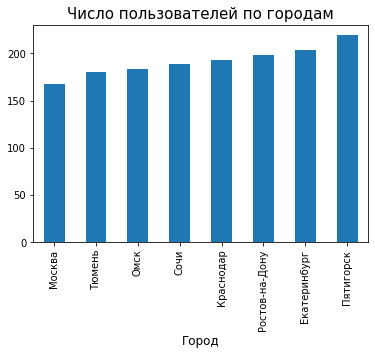

In [10]:
# Выведем основные стат. данные
df_users.groupby('city').count()['user_id'].sort_values().plot(kind='bar')
# Добавим название
plt.title('Число пользователей по городам', fontsize=15)
# Changing the x-axis label
plt.xlabel('Город', fontsize=12)

In [11]:
# Добавим таблицу с соответ. данными по городам
df_users.groupby('city').count()['user_id'].sort_values()

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: user_id, dtype: int64

### Соотношение пользователей с подпиской и без подписки**

Text(0, 0.5, '')

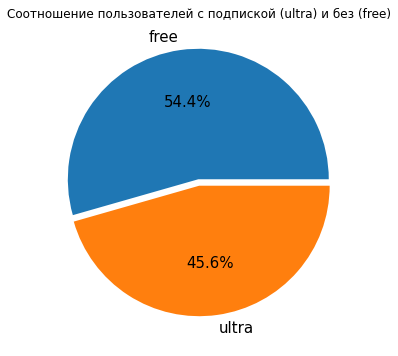

In [12]:
# Построим график
df_users.groupby('subscription_type').count()['user_id'].plot(
    kind='pie',
    fontsize=15,
    explode=(0.05, 0), 
    figsize=(6,6), 
    title='Соотношение пользователей с подпиской (ultra) и без (free)',
    autopct = '%1.1f%%' 
).set_ylabel('')

### Возраст пользователей

Text(0.5, 0, 'Возраст, лет')

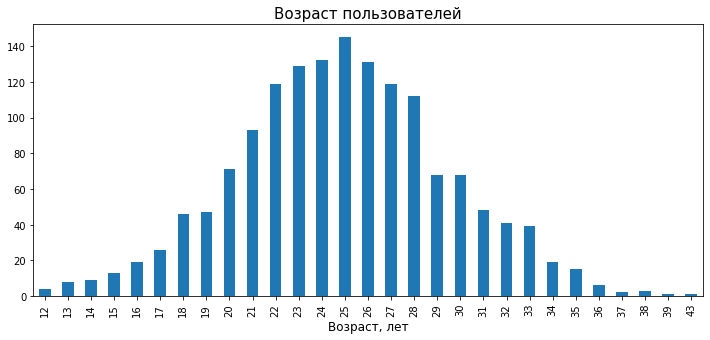

In [13]:
df_users.groupby('age').count()['user_id'].plot(kind='bar', figsize=(12,5))
plt.title('Возраст пользователей', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12)

Средний возраст пользователя составил 25 лет.

In [14]:
# Добавим также статистические данные по данному параметру
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

### Расстояние, которое пользователь преодолел за одну поездку

In [15]:
df_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0.5, 1.0, 'Histogram (дистанция поездки)')

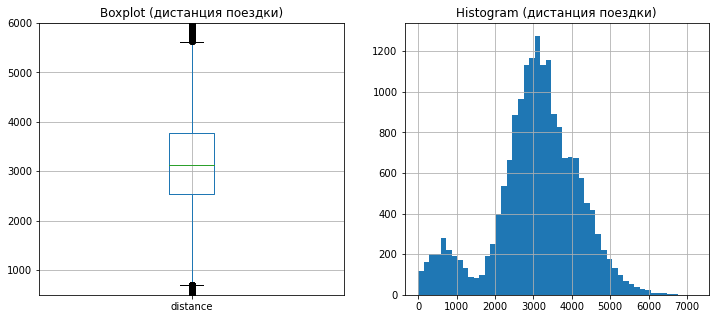

In [16]:
# Постороим графики на одном "полотне"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].set_ylim(500, 6000)
df_rides.boxplot(column="distance", ax=axes[0])
axes[0].set_title('Boxplot (дистанция поездки)')

df_rides["distance"].hist(bins=50, ax=axes[1])
axes[1].set_title('Histogram (дистанция поездки)')

# Усы - 693,7317975 и 5625,7172975

### Продолжительность поездок

In [17]:
df_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0.5, 1.0, 'Histogram (длительность поездки)')

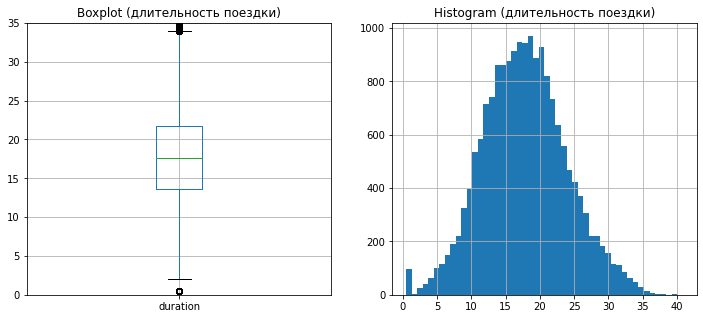

In [18]:
# Постороим графики на одном "полотне"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].set_ylim(0, 35)
df_rides.boxplot(column="duration", ax=axes[0])
axes[0].set_title('Boxplot (длительность поездки)')

df_rides["duration"].hist(bins=50, ax=axes[1])
axes[1].set_title('Histogram (длительность поездки)')

# Усы - 1,406707 и 33.915655

**Вывод**: В ходе исследовательского анализа выяснилось, что чаще всего сервисом пользуются в провинции, а реже в столице, при этом число пользователей с подпиской на 9% меньше числа пользователей без нее. Среднее расстояние преодолеваемое пользователем самоката составило 3133м, а среднее время примерно 18 минут. 

## Объединение данных

In [19]:
# Объединение данных о пользователях, поездках и подписках в один датафрейм
df_total = df_users.merge(df_rides, on='user_id').merge(df_subsc, on='subscription_type')
df_total.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [20]:
# Датафреймы с данными о пользователях с подпиской и без
df_no_sub = df_total.query('subscription_type != "ultra"')
df_sub = df_total.query('subscription_type == "ultra"')

In [21]:
# Проверим размерность полученных, чтобы убедиться, что ничего не потерялось
display(df_no_sub.shape[0] + df_sub.shape[0])
display(df_total.shape[0])

18068

18068

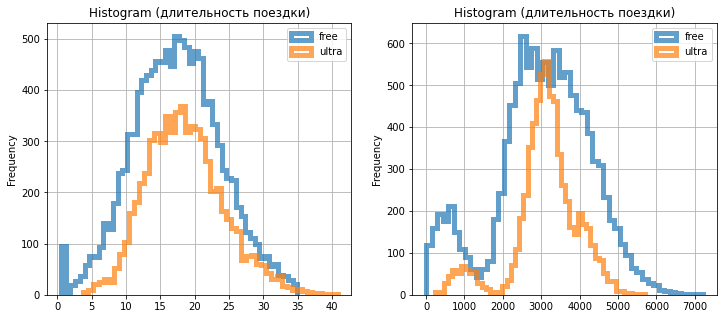

In [22]:
# Время поездки для пользователей с подпиской и без
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax0 = df_no_sub.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax = axes[0]
)
df_sub.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    ax=ax0,
    grid=True,
    legend=True,
)
axes[0].set_title('Histogram (длительность поездки)')

ax1 = df_no_sub.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax=axes[1],
)
df_sub.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    ax=ax1,
    grid=True,
    legend=True,
)
axes[1].set_title('Histogram (длительность поездки)')

plt.show()

**Вывод:** В данном разделе были объединены данные из 3 отдельных датафреймов и из них получены 2 новые: датафреймы с полной информации о пользователях с подпиской и без. По построенной выше паре гистограмм: длительности поездок (`duration`) видно что пользователи с подпиской и без в среднем тратят на поездку одинаковое кол-во времени (18 и 17 мин соответ.). Из гистограммы дистанций (`distance`): пользователи с подпиской и без в среднем проезжают примерно одинаковое расстояние (3148 и 3114 метров соответ.). 

## Подсчёт выручки

In [23]:
df_total['duration'] = np.ceil(df_total['duration']) # округлим до целого согл. ТЗ

In [24]:
# Суммарное расстояние, время и кол-во поездок для каждого пользователя за каждый месяц
df_sums = df_total.pivot_table(index=['user_id', 'month_num', 'subscription_type'], values=['distance', 'duration'], aggfunc={'distance': 'sum', 'duration': 'sum', 'user_id': 'count'})
df_sums.columns = ['total_distance', 'total_duration', 'count']
df_sums = df_sums.reset_index()
display(df_sums.head(10))

,user_id,month_num,subscription_type,total_distance,total_duration,count
0,1,1,ultra,7027.511294,42.0,2
1,1,4,ultra,754.159807,7.0,1
2,1,8,ultra,6723.470560,46.0,2
3,1,10,ultra,5809.911100,32.0,2
4,1,11,ultra,7003.499363,56.0,3
5,1,12,ultra,6751.629942,28.0,2
6,2,3,ultra,10187.723006,63.0,3
7,2,4,ultra,6164.381824,40.0,2
8,2,6,ultra,3255.338202,14.0,1
9,2,7,ultra,6780.722964,48.0,2


In [25]:
def month_prof(row):
    count = row['count']
    total_duration = row['total_duration']
    sub_type = row['subscription_type']
    start_price = df_subsc.query('subscription_type == @sub_type')['start_ride_price'].values[0]
    minute_price = df_subsc.query('subscription_type == @sub_type')['minute_price'].values[0] 
    sub_fee = df_subsc.query('subscription_type == @sub_type')['subscription_fee'].values[0]

    return start_price * count + minute_price * total_duration + sub_fee
   
df_sums['month_profit'] = df_sums.apply(month_prof, axis=1)
display(df_sums.head(10))

,user_id,month_num,subscription_type,total_distance,total_duration,count,month_profit
0,1,1,ultra,7027.511294,42.0,2,451.0
1,1,4,ultra,754.159807,7.0,1,241.0
2,1,8,ultra,6723.470560,46.0,2,475.0
3,1,10,ultra,5809.911100,32.0,2,391.0
4,1,11,ultra,7003.499363,56.0,3,535.0
5,1,12,ultra,6751.629942,28.0,2,367.0
6,2,3,ultra,10187.723006,63.0,3,577.0
7,2,4,ultra,6164.381824,40.0,2,439.0
8,2,6,ultra,3255.338202,14.0,1,283.0
9,2,7,ultra,6780.722964,48.0,2,487.0


**Вывод:** С помощью функции была получена информация о помесячной выручке на основе датафрефма агрегированных данных с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц. 

## Проверка гипотез

### Проверка гипотезы о большей продолжительности поездки для пользователей с подпиской

H0 (нулевая гипотеза) - предположение о том, что средняя продолжительность поездки пользователей с подпиской не отличается (равна) от таковой у пользователей без подписки.

H1 (альтернативная гипотеза) - предположение о том, что средняя продолжительность поездки пользователей с подпиской больше чем у пользователей без подписки.

In [26]:
df_sub = df_total.query('subscription_type == "ultra"')['duration']
df_nosub = df_total.query('subscription_type == "free"')['duration']
alpha = 0.05 # уровень стат значимости

results = st.ttest_ind(df_sub, df_nosub, alternative='greater')

print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не отвергается')

p-value:  2.4959453720736625e-34
Нулевая гипотеза отвергается


Нулевая гипотеза о равенстве средних 2-ух совокупностей отвергается - есть основания полагать, что пользователи с подпиской тратят больше времени на поездку, чем пользователи без нее.

### Проверка гипотезы о том, что среднее расстояние у пользователя с подпиской за поездку не более 3130м

H0 (нулевая гипотеза) - предположение о том, что среднее расстояние у пользователей с подпиской составляет 3130м.

H1 (альтернативная гипотеза) - предположение о том, что среднее расстояние у пользователей с подпиской больше 3130м.

In [27]:

df_sub_dist = df_total.query('subscription_type == "ultra"')['distance']
dist_limit = 3130
alpha = 0.05 

results = st.ttest_1samp(df_sub_dist, dist_limit, alternative='greater')

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не отвергается')

p-value:  0.9195368847849785
Нулевая гипотеза не отвергается


Значение p-value больше уровня стат. значимости, поэтому нулевая гипотеза не отвергается - пользователи с подпиской в среднем проезжают не более 3130м за поездку. 

### Проверка гипотезы о большей помесячной выручке от пользователей с подпиской (по месяцам)

H0 (нулевая гипотеза) - предположение о том, что помесячная выручка от пользователей с подпиской не отличается (равна) от таковой у пользователей без подписки.

H1 (альтернативная гипотеза) - предположение о том, что помесячная выручка от пользователей с подпиской больше чем у пользователей без подписки.

In [28]:
df_sub_profit = df_sums.query('subscription_type == "ultra"')['month_profit']
df_nosub_profit = df_sums.query('subscription_type == "free"')['month_profit']
alpha = 0.05

results = st.ttest_ind(df_sub_profit, df_nosub_profit, alternative='greater')

print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не отвергается')

p-value:  1.8850394384715216e-31
Нулевая гипотеза отвергается


Полученное значение p-value меньше заданного уровня значимости - нулевая гипотеза отвергается. Есть основания полагать, что помесячная выручка от пользователей с подпиской выше чем от пользователей без подписки.  

**Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

В данном сценарии описывается гипотеза о равенстве средних для зависимых (парных) выборок. Для проверки гипотезы в этом случае используется t-тест (статистический тест с использованием t-распределения Стьюдента) - мы использовали его для проверки вышеприведенных гипотез. Конкретно в данном случае должен быть использован метод `scipy.stats.ttest_rel()` - метод как раз для парных выборок.

**Вывод:** С использованием t-теста были приняты следущие гипотезы о пользователях с подпиской:
* Они тратят больше времени на поездку, чем пользователи без нее
* Они в среднем проезжают не более 3130м за поездку
* Помесячная выручка от них выше чем от пользователей без подписки.

## Распределения и статистические анализы промоакций

### Акция с раздачей промокодов на один бесплатный месяц подписки

Данный сценарий описывается биноминальным распределением с параметрами *n* - кол-во испытаний (ровно с 2 исходами) и *p* - вер-ть успеха в каждом испытании. Согласно ТЗ нам предлагается использовать метод cdf(), который возвращает вероятность того, что случайная величина меньше заданного аргумента. Для биноминального распределения она выглядит так: 

`binom.cdf(x, n, p)`, где `x` - это число успешных исходов - в нашем случае это 100 (число клиентов которые продлят подписку). Вообще данная функция возвращает нам вер-ть того, что будет получено `x` или меньше успешных исходов. Вер-ть не выполнить план должна составить 5% (т.е. менее 100 клиентов продлят подписку).

In [29]:
x = 100
p = 0.1
n = 1170 # определено подбором

prob_binom = st.binom.cdf(x, n, p)
display(prob_binom*100)

5.151491673741622

Подбором с помощью функции binom.cdf(x, n, p) определили что необходимо раздать примерно 1170 промокодов.

### Рассылка push-уведомлений
Данный сценарий описывается также биноминальным распределением. Однако для упрощения расчетов будет лучше аппроксимировать его нормальным распределением. 

Text(0.5, 0, 'Число пользователей')

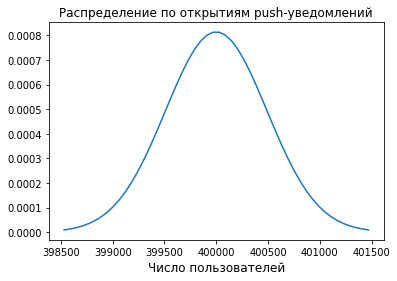

In [30]:
# Параметры бином. распределения
n = 1e6
p = 0.4

# Мат. ожидание и СКО норм. распределения принимаются равными соотв. значениям бином. распределения
mu = n * p
sigma = (n * p * (1 - p))**(1/2)

# Норм. распределение и его график
distr = st.norm(mu, sigma)
x_values = np.linspace(mu - 3*sigma, mu + 3*sigma)
plt.plot(x_values, distr.pdf(x_values), label='Normal Distribution')
plt.title('Распределение по открытиям push-уведомлений')
plt.xlabel('Число пользователей', fontsize=12)

In [31]:
# Оценим вер-ть того, что , уведомление откроют не более 399,5 тыс. пользователей
result = distr.cdf(399500)
display(result)

0.15371708296369768

## Общие выводы

Типичный пользователь сервиса аренды самокатов GoFast:
* Находится в провинции
* Не имееет подписки в сервисе
* Возраст 25 лет
* Проезжает 3133м
* Тратит на поездку 17,6мин

Пользователи с подпиской тратят на поездку чуть больше времени и проезжают чуть большее расстояние чем пользователи без подписки. Первое утверждение также было рассмотрено в виде гипотезы, которая в итоге оказалась принята. Также были рассмотрены гипотезы о том, что пользователи с подпиской пpоезжают менее 3130м (расстояние износа самоката) и помесячная выручка от них больше таковой от пользователей без подписки. 

Из вышеприведенного можно заключить, что для сервиса наиболее выгоден пользователь с подпиской, так как доходы от данной категории выше, и при этом, несмотря на то что, они проезжают чуть большее расстояние чем обычные пользователи, они (пользователи с подпиской) не успевают выработать весь ресурс самоката. 

Также дополнительно был проведен анализ акции по раздаче промокодов на 1 месяц бесплатной подписки: для того, чтобы с 95% вероятностью как минимум 100 пользователей продлили платно подписку, будет необходимо разослать примерно 1170 промокодов. 
Дополнительно была определена вероятность того, что 399,5тыс клиентов сервиса откроют рассылаемые push-уведомления, которая составила 15% - в принципе, немного и на просмотр уведомлений 399,5 тыс. пользователей можно рассчитывать.  